**Initialization**

In [1]:
import numpy as np
import os
import math

import functools
import platform
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

from network import ResNet18, RClassifier, SSClassifier, weights_init, set_Evaluation
from data_gen import DatasetGenerator, RotateTransformer, JP_Transformer, load_image, get_relative_rotation, get_relative_jig
from utilities import entropy_loss, OptimizerManager, IteratorWrapper, map_to_device, plotter

**Set Arguments**

In [2]:
device = torch.device('cuda')
DATA_DIR = ""
NUM_CLASSES = 47 #ignore_class = ['lime', 'onion', 'tomato', 'peach']
net_architecture = 'resnet18'
input_dim_F = 512 #resnet input dim.
mode = 'jigsaw_puzzle' # 'jigsaw_puzzle' or 'rotation' or 'source_only'
batch_size = 32
NUM_EPOCH = 15 
lr = 0.0001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.05 #L2 regularizer
# ------------------------------------------------------------------------
lambda_ss = 1  #regularization_ss
lambda_ent = 0.1 #weight for Entropy as a DA specific regularization #regularization_ent
dropout_p=0.5 
# ------------------------------------------------------------------------
lr_drop=1 #drop multiplication for lr
#acc_threshold=0.63
# ------------------------------------------------------------------------
train_Rod_path="split_sync.txt"
train_synrod_path="synROD_paths.txt"
test_Rod_path="split_sync.txt"
test_synrod_path="synROD_paths.txt"
# ------------------------------------------------------------------------
grid_num=4 #grid_num=n*n puzzle
permutation_num=24 #number of permutaions of puzzle (e.g for 2*2 is equal to 4!=24)
# ------------------------------------------------------------------------
myurl="C:\\Users\\hadin\\projectdl\\testnew\\"
suffix=""
tensorboard="tensorboard"
hp_list = [net_architecture, mode, NUM_EPOCH, lr, batch_size,lambda_ss,lambda_ent]
hp_list = [str(hp) for hp in hp_list]
hp_string = '_'.join(hp_list) + suffix
print("Run: " + hp_string)
writer = SummaryWriter(log_dir=os.path.join(tensorboard, hp_string), flush_secs=5)
output_path="C:\\Users\\hadin\\projectdl\\testnew\\"

Run: resnet18_jigsaw_puzzle_15_0.0001_32_1_0.1


**Prepare Dataset**

In [3]:
if mode=='jigsaw_puzzle':
    # Source: training set
    train_set_source = DatasetGenerator(DATA_DIR,train_synrod_path,mode, JP=False, dtype='synROD',grid_num=grid_num,permutation_num=permutation_num)
    test_set_source = DatasetGenerator(DATA_DIR,test_synrod_path,mode, JP=False, dtype='synROD',grid_num=grid_num,permutation_num=permutation_num)
    # Target: training set (for entropy)
    train_set_target = DatasetGenerator(DATA_DIR,train_Rod_path,mode, JP=False, dtype='ROD',grid_num=grid_num,permutation_num=permutation_num)
    # Source: training set (for relative rotation)
    rot_set_source = DatasetGenerator(DATA_DIR,train_synrod_path,mode, JP=True, dtype='synROD',grid_num=grid_num,permutation_num=permutation_num)
    # Source: test set (for relative rotation)
    rot_test_set_source = DatasetGenerator(DATA_DIR,test_synrod_path,mode, JP=True, dtype='synROD',grid_num=grid_num,permutation_num=permutation_num)
    # Target: training and test set (for relative rotation)
    rot_set_target = DatasetGenerator(DATA_DIR,train_Rod_path,mode, JP=True, dtype='ROD',grid_num=grid_num,permutation_num=permutation_num)

elif mode=="rotation":
    test_transform = RotateTransformer([int((256 - 224) / 2), int((256 - 224) / 2)], False)
    # Source: training set
    train_set_source = DatasetGenerator(DATA_DIR,train_synrod_path,mode, do_rot=False, dtype='synROD')
    test_set_source = DatasetGenerator(DATA_DIR,test_synrod_path,mode, do_rot=False, dtype='synROD',transform=test_transform)
    # Target: training set (for entropy)
    train_set_target = DatasetGenerator(DATA_DIR,train_Rod_path,mode, do_rot=False, dtype='ROD')
    # Source: training set (for relative rotation)
    rot_set_source = DatasetGenerator(DATA_DIR,train_synrod_path,mode, do_rot=True, dtype='synROD')
    # Source: test set (for relative rotation)
    rot_test_set_source = DatasetGenerator(DATA_DIR,test_synrod_path,mode, do_rot=True, dtype='synROD')
    # Target: training and test set (for relative rotation)
    rot_set_target = DatasetGenerator(DATA_DIR,train_Rod_path,mode, do_rot=True, dtype='ROD')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


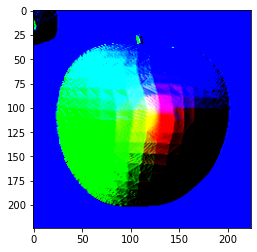

In [4]:
#check data generator batch
a=iter(train_set_source)
batch=next(a)
# print(batch.shape)
img= batch[1]
plt.imshow(img.squeeze().permute(1, 2, 0))

**Set Dataloader**

In [5]:
# Source training recognition
train_loader_source = DataLoader(train_set_source,shuffle=True,batch_size=batch_size)

# Source test recognition
test_loader_source = DataLoader(test_set_source,shuffle=True,batch_size=batch_size)

# Target train
train_loader_target = DataLoader(train_set_target,shuffle=True,batch_size=batch_size)

# Target test
test_loader_target = DataLoader(train_set_target,shuffle=True,batch_size=batch_size)
# Source rot
rot_source_loader = DataLoader(rot_set_source,shuffle=True,batch_size=batch_size)

rot_test_source_loader = DataLoader(rot_test_set_source,shuffle=True,batch_size=batch_size)
# Target rot
rot_target_loader = DataLoader(rot_set_target,shuffle=True,batch_size=batch_size)

rot_test_target_loader = DataLoader(rot_set_target,shuffle=True,batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


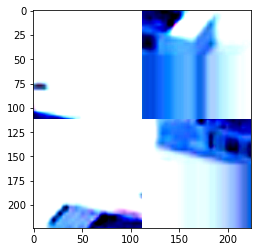

In [6]:
#Accessing Data in the training set and checking Data loader Class
#check transformed data  batch
batch=next(iter(rot_test_target_loader))
img= batch[0][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

**Set Network & Optimizer**

In [7]:
net_rgb = ResNet18() #feature extract
net_depth = ResNet18() #feature extract
netF = RClassifier(input_dim=input_dim_F * 2, class_num=NUM_CLASSES, dropout_p=dropout_p, extract=False) #recognition
netF_rot = SSClassifier(input_dim=input_dim_F * 2, class_num=permutation_num) #self-supervision
netF_rot.apply(weights_init)
netF.apply(weights_init)

net_list = [net_rgb, net_depth, netF, netF_rot]
net_list = map_to_device(device, net_list)

In [8]:
ce_loss = nn.CrossEntropyLoss()

opt_g_rgb = optim.SGD(net_rgb.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
opt_g_depth = optim.SGD(net_depth.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
opt_f = optim.SGD(netF.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
opt_f_rot = optim.SGD(netF_rot.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

optims_list = [opt_g_rgb, opt_g_depth, opt_f, opt_f_rot]

**Train & Validation**

In [9]:
#recognition source vals
vis_Loss_train=[]
vis_Loss_val=[]
vis_Accuracy_val=[]
#recognition target vals
vis_Loss_val_target=[]
vis_Accuracy_val_target=[]
#rotation
vis_Loss_rot_train=[]
vis_Loss_rot_val=[]
vis_Accuracy_rot_val=[]

test_batches = len(train_loader_source)-1 #number of batches to loop over for testing=validating
    
for epoch in range(1, NUM_EPOCH + 1):
    print("Epoch {} / {}".format(epoch, NUM_EPOCH))

    # Train source (recognition)
    train_loader_source_rec_iter = train_loader_source
    # Train target (entropy)
    train_target_loader_iter = IteratorWrapper(train_loader_target)
    # Test target
    test_target_loader_iter = IteratorWrapper(test_loader_target)

    # Source (rotation)
    rot_source_loader_iter = IteratorWrapper(rot_source_loader)
    # Target (rotation)
    rot_target_loader_iter = IteratorWrapper(rot_target_loader)

    with tqdm(total=len(train_loader_source), desc="Train") as pb:
        for batch_num, (img_rgb, img_depth, img_label_source) in enumerate(train_loader_source_rec_iter):
            if img_rgb.size(0) != batch_size:
                break
            # The optimization step is performed by OptimizerManager
            with OptimizerManager(optims_list):
                # Compute source features
                img_rgb, img_depth, img_label_source = map_to_device(device, (img_rgb, img_depth, img_label_source))
                feat_rgb, _ = net_rgb(img_rgb)
                feat_depth, _ = net_depth(img_depth)
                features_source = torch.cat((feat_rgb, feat_depth), 1)
                logits = netF(features_source)

                # Classification loss
                loss_rec = ce_loss(logits, img_label_source)

                # Entropy loss
                if lambda_ent > 0.:
                    # Compute target features
                    img_rgb, img_depth, _ = train_target_loader_iter.get_next()
                    img_rgb, img_depth = map_to_device(device, (img_rgb, img_depth))
                    feat_rgb, _ = net_rgb(img_rgb)
                    feat_depth, _ = net_depth(img_depth)
                    features_target = torch.cat((feat_rgb, feat_depth), 1)
#                     print(features_source.shape)
                    logits = netF(features_target)

                    loss_ent = entropy_loss(logits) #here by calculating this we can find a measure for doamin shift because this is taking into account the entropy difference between two domains
                else:
                    loss_ent = 0

                # Backpropagate
                loss = loss_rec + lambda_ent * loss_ent
                loss.backward()

                del img_rgb, img_depth, img_label_source, feat_rgb, feat_depth, logits

                # Relative Rotation
                if lambda_ss > 0.0:
                    # Load batch: rotation, source
                    img_rgb, img_depth, _, rot_label = rot_source_loader_iter.get_next()
                    img_rgb, img_depth, rot_label = map_to_device(device, (img_rgb, img_depth, rot_label))

                    # Compute features (without pooling!)
                    _, pooled_rgb = net_rgb(img_rgb)
                    _, pooled_depth = net_depth(img_depth)
                    # Prediction
                    logits_rot = netF_rot(torch.cat((pooled_rgb, pooled_depth), 1))

                    # Classification loss for the rleative rotation task
                    loss_rot = ce_loss(logits_rot, rot_label)
                    loss = lambda_ss * loss_rot
                    # Backpropagate
                    loss.backward()

                    loss_rot = loss_rot.item()

                    del img_rgb, img_depth, rot_label, pooled_rgb, pooled_depth, logits_rot, loss

                    # Load batch: rotation, target
                    img_rgb, img_depth, _, rot_label = rot_target_loader_iter.get_next()
                    img_rgb, img_depth, rot_label = map_to_device(device, (img_rgb, img_depth, rot_label))

                    # Compute features (without pooling!)
                    _, pooled_rgb = net_rgb(img_rgb)
                    _, pooled_depth = net_depth(img_depth)
                    # Prediction
                    logits_rot = netF_rot(torch.cat((pooled_rgb, pooled_depth), 1))

                    # Classification loss for the rleative rotation task
                    loss = lambda_ss * ce_loss(logits_rot, rot_label)
                    # Backpropagate
                    loss.backward()
                    #print(loss)
                    del img_rgb, img_depth, rot_label, pooled_rgb, pooled_depth, logits_rot, loss

                pb.update(1)
# Recognition - source
    actual_test_batches = min(len(test_loader_source), test_batches)
    with set_Evaluation(net_list), tqdm(total=actual_test_batches, desc="Validation-Recognition-S") as pb:
        test_source_loader_iter = iter(test_loader_source)
        correct = 0.0
        num_predictions = 0.0
        val_loss = 0.0
        for num_batch, (img_rgb, img_depth, img_label_source) in enumerate(test_source_loader_iter):
            # By default validate only on 100 batches
            if num_batch >= test_batches:
                break

            # Compute source features
            img_rgb, img_depth, img_label_source = map_to_device(device, (img_rgb, img_depth, img_label_source))
            feat_rgb, _ = net_rgb(img_rgb)
            feat_depth, _ = net_depth(img_depth)
            features_source = torch.cat((feat_rgb, feat_depth), 1)

            # Compute predictions
            preds = netF(features_source)

            val_loss += ce_loss(preds, img_label_source).item()
            correct += (torch.argmax(preds, dim=1) == img_label_source).sum().item()
            num_predictions += preds.shape[0]

            pb.update(1)

        val_acc = correct / num_predictions
        val_loss = val_loss / test_batches
        print("Epoch: {} - Validation source accuracy (recognition): {}".format(epoch, val_acc))

    del img_rgb, img_depth, img_label_source, feat_rgb, feat_depth, preds

    writer.add_scalar("Loss/train", loss_rec.item(), epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    
    vis_Loss_train.append(loss_rec.item())
    vis_Loss_val.append(val_loss)
    vis_Accuracy_val.append(val_acc)
    
# Recognition - target
    actual_test_batches = min(len(test_loader_target), test_batches)
    with set_Evaluation(net_list), tqdm(total=actual_test_batches, desc="Validation-Recognition-T") as pb:
        test_target_loader_iter = iter(test_loader_target)
        correct = 0.0
        num_predictions = 0.0
        val_loss_target = 0.0
        for num_batch, (img_rgb, img_depth, img_label_target) in enumerate(test_target_loader_iter):
            # By default validate only on 100 batches
            if num_batch >= test_batches:
                break

            # Compute source features
            img_rgb, img_depth, img_label_target = map_to_device(device, (img_rgb, img_depth, img_label_target))
            feat_rgb, _ = net_rgb(img_rgb)
            feat_depth, _ = net_depth(img_depth)
            features_target = torch.cat((feat_rgb, feat_depth), 1)

            # Compute predictions
            preds = netF(features_target)

            val_loss_target += ce_loss(preds, img_label_target).item()
            correct += (torch.argmax(preds, dim=1) == img_label_target).sum().item()
            num_predictions += preds.shape[0]

            pb.update(1)

        val_acc_target = correct / num_predictions
        val_loss_target = val_loss_target / test_batches
        print("Epoch: {} - Validation target accuracy (recognition): {}".format(epoch, val_acc_target))

    del img_rgb, img_depth, img_label_target, feat_rgb, feat_depth, preds

    writer.add_scalar("Loss/val_target", val_loss_target, epoch)
    writer.add_scalar("Accuracy/val_target", val_acc_target, epoch)
    
    vis_Loss_val_target.append(val_loss_target)
    vis_Accuracy_val_target.append(val_acc_target)
    
    
    # Relative Rotation
    if lambda_ss > 0.0:

        # Rotation - source
        cf_matrix = np.zeros([permutation_num, permutation_num])
        actual_test_batches = min(len(rot_test_source_loader), test_batches)
        with set_Evaluation(net_list), tqdm(total=actual_test_batches, desc="Validation-Pretext-S") as pb:
            rot_test_source_loader_iter = iter(rot_test_source_loader)
            correct = 0.0
            num_predictions = 0.0
            for num_val_batch, (img_rgb, img_depth, _, rot_label) in enumerate(rot_test_source_loader_iter):
                if num_val_batch > test_batches:
                    break
                img_rgb, img_depth, rot_label = map_to_device(device, (img_rgb, img_depth, rot_label))

                # Compute features (without pooling)
                _, pooled_rgb = net_rgb(img_rgb)
                _, pooled_depth = net_depth(img_depth)
                # Compute predictions
                preds = netF_rot(torch.cat((pooled_rgb, pooled_depth), 1))

                val_loss_rot = ce_loss(preds, rot_label).item()
                correct += (torch.argmax(preds, dim=1) == rot_label).sum().item()
                num_predictions += preds.shape[0]

                pb.update(1)

            del img_rgb, img_depth, rot_label, preds

            rot_val_acc = correct / num_predictions
#             print("Epoch: {} - Validation source rotation accuracy: {}".format(epoch, rot_val_acc))

        # Rotation - target
        actual_test_batches = min(len(rot_test_target_loader), test_batches)
        with set_Evaluation(net_list), tqdm(total=actual_test_batches, desc="Validation-Pretext-T") as pb:
            rot_test_target_loader_iter = iter(rot_test_target_loader)
            correct = 0.0
            val_loss_rot = 0.0
            num_predictions = 0.0
            for num_val_batch, (img_rgb, img_depth, _, rot_label) in enumerate(rot_test_target_loader_iter):
                if num_val_batch > test_batches:
                    break

                img_rgb, img_depth, rot_label = map_to_device(device, (img_rgb, img_depth, rot_label))

                # Compute features (without pooling)
                _, pooled_rgb = net_rgb(img_rgb)
                _, pooled_depth = net_depth(img_depth)
                # Compute predictions
                preds = netF_rot(torch.cat((pooled_rgb, pooled_depth), 1))

                val_loss_rot += ce_loss(preds, rot_label).item()
                correct += (torch.argmax(preds, dim=1) == rot_label).sum().item()
                num_predictions += preds.shape[0]

                pb.update(1)

            rot_val_acc = correct / num_predictions
            val_loss_rot = val_loss_rot / test_batches
            print("Epoch: {} - Validation target rotation accuracy: {}".format(epoch, rot_val_acc))
            print("-------------------------------------------------------------------------------")

        del img_rgb, img_depth, rot_label, preds

        writer.add_scalar("Loss/rot", loss_rot, epoch)
        writer.add_scalar("Loss/rot_val", val_loss_rot, epoch)
        writer.add_scalar("Accuracy/rot_val", rot_val_acc, epoch)
        
        vis_Loss_rot_train.append(loss_rot)
        vis_Loss_rot_val.append(val_loss_rot)
        vis_Accuracy_rot_val.append(rot_val_acc)
        
        #lr scheduler for accuracy threshold
        if epoch >= 2:
            if vis_Accuracy_val_target[epoch-1] >= vis_Accuracy_val_target[epoch-2]:
                continue
            else:
                lr*=lr_drop
                print(lr)

    # Save models
    if epoch % 1 == 0:
        if not os.path.exists(myurl):
            os.mkdir(myurl)

        torch.save(net_rgb.state_dict(),
                   os.path.join(myurl, hp_string + "_net_rgb_epoch" + str(epoch) + ".pth"))
        torch.save(net_depth.state_dict(),
                   os.path.join(myurl, hp_string + "_net_depth_epoch" + str(epoch) + ".pth"))
        torch.save(netF.state_dict(), os.path.join(myurl, hp_string + "_netF_rgbd_epoch" + str(epoch) + ".pth"))
        torch.save(netF_rot.state_dict(),
                   os.path.join(myurl, hp_string + "_netF_rot_rgbd_epoch" + str(epoch) + ".pth"))
writer.close()

Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch 1 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:43,  6.19it/s]

Epoch: 1 - Validation source accuracy (recognition): 0.7632207247411639


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 1 - Validation target accuracy (recognition): 0.5688200517305086


Validation-Pretext-S: 2802it [09:35,  4.87it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:52<00:00,  5.89it/s]


Epoch: 1 - Validation target rotation accuracy: 0.078765857864269
-------------------------------------------------------------------------------


Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch 2 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:56,  5.73it/s]

Epoch: 2 - Validation source accuracy (recognition): 0.835973759371653


Validation-Pretext-S:   0%|          | 1/2801 [00:00<08:44,  5.33it/s]

Epoch: 2 - Validation target accuracy (recognition): 0.6092191156546373


Validation-Pretext-S: 2802it [09:36,  4.86it/s]                          
Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch: 2 - Validation target rotation accuracy: 0.09662520014780146
-------------------------------------------------------------------------------
Epoch 3 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:35,  6.51it/s]

Epoch: 3 - Validation source accuracy (recognition): 0.867368796858265


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 3 - Validation target accuracy (recognition): 0.6320359650203227


Validation-Pretext-S: 2802it [09:36,  4.86it/s]                          
Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch: 3 - Validation target rotation accuracy: 0.16667693065648478
-------------------------------------------------------------------------------
Epoch 4 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:27,  6.87it/s]

Epoch: 4 - Validation source accuracy (recognition): 0.8891802034987505


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 4 - Validation target accuracy (recognition): 0.6108510900357187


Validation-Pretext-S: 2802it [09:34,  4.88it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:52<00:00,  5.88it/s]


Epoch: 4 - Validation target rotation accuracy: 0.320359650203227
-------------------------------------------------------------------------------
0.0001
Epoch 5 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:34,  6.55it/s]

Epoch: 5 - Validation source accuracy (recognition): 0.9056921635130311


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 5 - Validation target accuracy (recognition): 0.6046311122059367


Validation-Pretext-S: 2802it [09:32,  4.89it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:52<00:00,  5.89it/s]


Epoch: 5 - Validation target rotation accuracy: 0.4983680256189186
-------------------------------------------------------------------------------
0.0001
Epoch 6 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:33,  6.60it/s]

Epoch: 6 - Validation source accuracy (recognition): 0.9233532666904677


Validation-Pretext-S:   0%|          | 1/2801 [00:00<08:36,  5.42it/s]

Epoch: 6 - Validation target accuracy (recognition): 0.5920987806380096


Validation-Pretext-S: 2802it [09:33,  4.88it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:52<00:00,  5.87it/s]


Epoch: 6 - Validation target rotation accuracy: 0.6469700702056903
-------------------------------------------------------------------------------
0.0001
Epoch 7 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:50,  5.93it/s]

Epoch: 7 - Validation source accuracy (recognition): 0.9296679757229561


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 7 - Validation target accuracy (recognition): 0.5823377263209755


Validation-Pretext-S: 2802it [09:32,  4.89it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:52<00:00,  5.88it/s]


Epoch: 7 - Validation target rotation accuracy: 0.7594839265919449
-------------------------------------------------------------------------------
0.0001


Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch 8 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:25,  6.96it/s]

Epoch: 8 - Validation source accuracy (recognition): 0.9399879507318815


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 8 - Validation target accuracy (recognition): 0.5783347702919078


Validation-Pretext-S: 2802it [09:37,  4.85it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:53<00:00,  5.85it/s]


Epoch: 8 - Validation target rotation accuracy: 0.86953442542185
-------------------------------------------------------------------------------
0.0001
Epoch 9 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<03:01,  5.60it/s]

Epoch: 9 - Validation source accuracy (recognition): 0.9412821313816494


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 9 - Validation target accuracy (recognition): 0.57531715728538


Validation-Pretext-S: 2802it [09:41,  4.82it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:56<00:00,  5.76it/s]


Epoch: 9 - Validation target rotation accuracy: 0.896600566572238
-------------------------------------------------------------------------------
0.0001
Epoch 10 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:52,  5.86it/s]

Epoch: 10 - Validation source accuracy (recognition): 0.94288870046412


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 10 - Validation target accuracy (recognition): 0.5698977706614115


Validation-Pretext-S: 2802it [09:41,  4.82it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:56<00:00,  5.75it/s]


Epoch: 10 - Validation target rotation accuracy: 0.9188631604877447
-------------------------------------------------------------------------------
0.0001


Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch 11 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:57,  5.70it/s]

Epoch: 11 - Validation source accuracy (recognition): 0.9557858800428418


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 11 - Validation target accuracy (recognition): 0.5771646754526419


Validation-Pretext-S: 2802it [09:41,  4.82it/s]                          
Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch: 11 - Validation target rotation accuracy: 0.9247444266535287
-------------------------------------------------------------------------------
Epoch 12 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:47,  6.04it/s]

Epoch: 12 - Validation source accuracy (recognition): 0.943390753302392


Validation-Pretext-S:   0%|          | 1/2801 [00:00<09:26,  4.94it/s]

Epoch: 12 - Validation target accuracy (recognition): 0.5723303362483064


Validation-Pretext-S: 2802it [09:41,  4.82it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:55<00:00,  5.79it/s]


Epoch: 12 - Validation target rotation accuracy: 0.9443897031654145
-------------------------------------------------------------------------------
0.0001
Epoch 13 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:55,  5.76it/s]

Epoch: 13 - Validation source accuracy (recognition): 0.9294894680471261


Validation-Pretext-S:   0%|          | 1/2801 [00:00<08:31,  5.48it/s]

Epoch: 13 - Validation target accuracy (recognition): 0.5687276758221456


Validation-Pretext-S: 2802it [09:44,  4.79it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:55<00:00,  5.77it/s]


Epoch: 13 - Validation target rotation accuracy: 0.9452826702795911
-------------------------------------------------------------------------------
0.0001


Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch 14 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:38,  6.39it/s]

Epoch: 14 - Validation source accuracy (recognition): 0.9492145662263477


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 14 - Validation target accuracy (recognition): 0.5704520261115901


Validation-Pretext-S: 2802it [09:45,  4.78it/s]                          
Train:   0%|          | 0/2802 [00:00<?, ?it/s]

Epoch: 14 - Validation target rotation accuracy: 0.9458061337603153
-------------------------------------------------------------------------------
Epoch 15 / 15


Validation-Recognition-T:   0%|          | 1/1015 [00:00<02:34,  6.55it/s]

Epoch: 15 - Validation source accuracy (recognition): 0.9346215637272403


Validation-Pretext-S:   0%|          | 0/2801 [00:00<?, ?it/s]

Epoch: 15 - Validation target accuracy (recognition): 0.5600751324054687


Validation-Pretext-S: 2802it [09:41,  4.82it/s]                          
Validation-Pretext-T: 100%|██████████| 1015/1015 [02:55<00:00,  5.80it/s]


Epoch: 15 - Validation target rotation accuracy: 0.9615716221209508
-------------------------------------------------------------------------------
0.0001


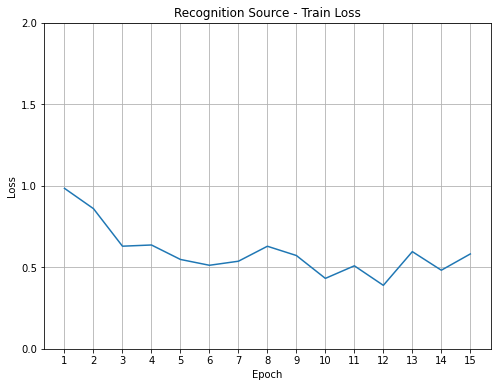

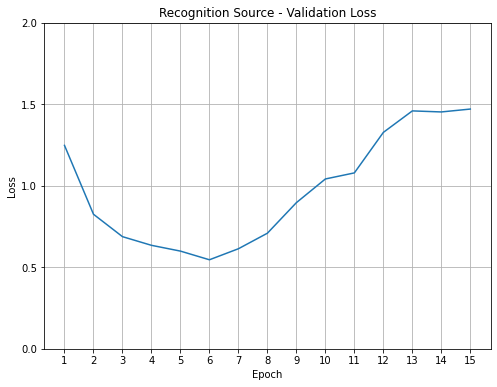

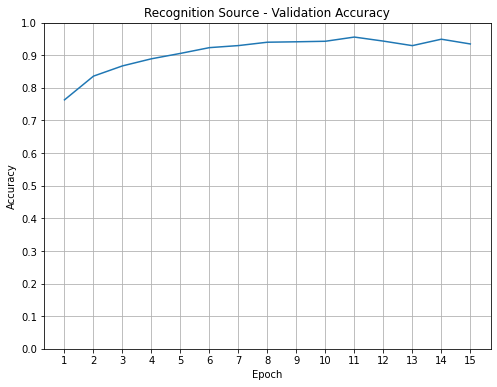

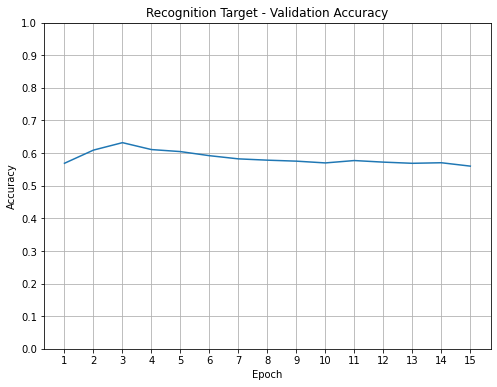

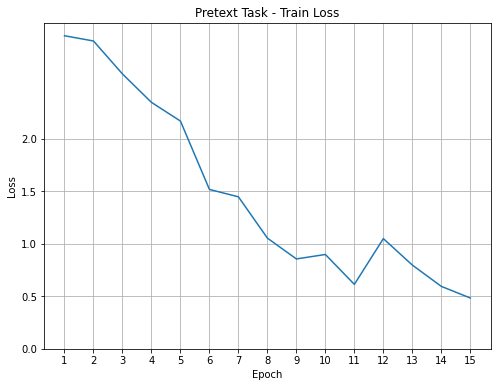

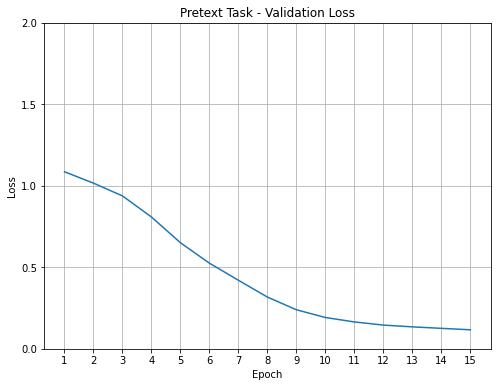

In [20]:
#overview plot
#recognition source vals
p_Loss_train=plotter(range(1, len(vis_Loss_train)+1), vis_Loss_train, title="Recognition Source - Train Loss", y_label="Loss")
p_Loss_val=plotter(range(1, len(vis_Loss_val)+1), vis_Loss_val, title="Recognition Source - Validation Loss", y_label="Loss")
p_Accuracy_val=plotter(range(1, len(vis_Accuracy_val)+1), vis_Accuracy_val, title="Recognition Source - Validation Accuracy", y_label="Accuracy")
#recognition target vals
# p_Loss_val_target=plotter(range(1, len(vis_Loss_val_target)+1), vis_Loss_val_target, title="Recognition Target - Validation Loss", y_label="Loss")
p_Accuracy_val_target=plotter(range(1, len(vis_Accuracy_val_target)+1), vis_Accuracy_val_target, title="Recognition Target - Validation Accuracy", y_label="Accuracy")
#rotation
p_Loss_rot_train=plotter(range(1, len(vis_Loss_rot_train)+1), vis_Loss_rot_train, title="Pretext Task - Train Loss", y_label="Loss")
p_Loss_rot_val=plotter(range(1, len(vis_Accuracy_val_target)+1), vis_Loss_rot_val, title="Pretext Task - Validation Loss", y_label="Loss")

In [21]:
#save loss and accuracy OUTPUT values for later to be used in stacked graphs
import pandas as pd

vis_Loss_train
vis_Loss_val
vis_Accuracy_val
#recognition target vals
vis_Loss_val_target
vis_Accuracy_val_target
#rotation
vis_Loss_rot_train
vis_Loss_rot_val
vis_Accuracy_rot_val

df = pd.DataFrame() 
df['vis_Loss_train'] = vis_Loss_train
df['vis_Loss_val'] = vis_Loss_val
df['vis_Accuracy_val'] = vis_Accuracy_val
df['vis_Loss_val_target'] = vis_Loss_val_target
df['vis_Accuracy_val_target'] = vis_Accuracy_val_target
df['vis_Loss_rot_train'] = vis_Loss_rot_train
df['vis_Loss_rot_val'] = vis_Loss_rot_val
df['vis_Accuracy_rot_val'] = vis_Accuracy_rot_val
df.to_csv('jig-test-1', float_format=None, columns=None, header=True, index=None)